<a href="https://colab.research.google.com/github/nestorbalcazar/nestorbalcazar.github.io/blob/master/NumMethods_ConductionCylinder1D_Implicit_Ex00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Fe cyl] N=200: iters=110893, Tmin=425.312, Tmax=487.500
N=200 | L_inf = 3.906e-04 K | L2 = 3.906e-04 K

Energy balance (per unit length):
  Q_gen         = 1.570796e+04 W/m
  Q_conv_exact  = 1.570796e+04 W/m
  Q_conv_num    = 1.570796e+04 W/m
  |Q_gen - Q_conv_exact| / Q_gen = 1.158e-16
  |Q_gen - Q_conv_num|   / Q_gen = 1.561e-11


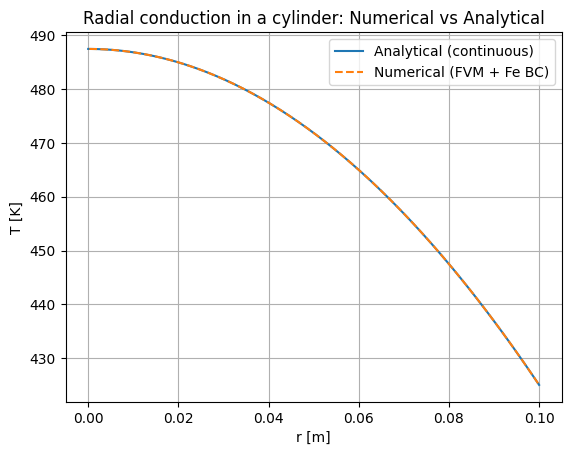

In [2]:
# --- Radial 1D conduction in a solid cylinder (per unit axial length) ---
# PDE (steady, λ and qdot constants):
#   (1/r) d/dr ( r λ dT/dr ) + qdot = 0
# BCs:
#   r = 0   : symmetry (dT/dr = 0)
#   r = R   : convection to ambient: -λ dT/dr|_R = α (T_s - T_inf)
# Discretization: Finite Volume Method (FVM), centroid-to-centroid distances
# Boundary at r=R enforced via series resistance:
#   Fe = A_s / ( 1/alpha + Δr/λ ), with Δr = (R - r_P_last), A_s = 2π R (per unit length)

import numpy as np
import matplotlib.pyplot as plt

# -------- Physical parameters --------
R       = 0.10        # [m] cylinder radius
lam     = 20.0        # [W/(m·K)] thermal conductivity (constant)
qdot    = 5.0e5       # [W/m^3] volumetric heat generation (constant)
alpha   = 200.0       # [W/(m^2·K)] convection coefficient
T_inf   = 300.0       # [K] ambient temperature
Lz      = 1.0         # [m] axial length considered (per unit length)
A_s     = 2.0*np.pi*R*Lz   # [m^2] lateral surface area per unit length

# -------- Analytical solution (true Robin at r=R) --------
# For constants and symmetry at r=0, the exact solution is:
#   T(r) = T_inf + (qdot/(2*alpha)) R + (qdot/(4*lam)) (R^2 - r^2)
def T_analytical(r):
    return T_inf + (qdot/(2.0*alpha))*R + (qdot/(4.0*lam))*(R**2 - r**2)

# -------- Solver: FVM assembly + GS/SOR (Robin via Fe) --------
def solve_fvm_cylinder(N, omega=1.7, tol=1e-12, itmax=200000, verbose=False):
    """
    Builds and solves the 1D radial FVM system in a cylinder with Robin BC at r=R
    enforced via the series-resistance coefficient Fe. Distances are centroid-to-centroid;
    face areas are evaluated at faces. Per unit axial length (Lz).
    """
    # Mesh: faces and centroids
    r_f = np.linspace(0.0, R, N+1)           # face radii
    r_c = 0.5*(r_f[:-1] + r_f[1:])           # cell centroids

    # Geometric factors (per unit length Lz)
    Aw  = 2.0*np.pi*r_f[:-1]*Lz              # west-face area of cell i (at r_f[i])
    Ae  = 2.0*np.pi*r_f[1:]*Lz               # east-face area of cell i (at r_f[i+1])
    Vp  = np.pi*(r_f[1:]**2 - r_f[:-1]**2)*Lz  # cell volumes

    # Centroid-to-centroid distances
    dWP = np.zeros(N)        # Δr_WP = r_P - r_W
    dPE = np.zeros(N)        # Δr_PE = r_E - r_P
    dWP[1:]  = r_c[1:] - r_c[:-1]
    dPE[:-1] = r_c[1:] - r_c[:-1]

    # Linear system: aP*T_P = aE*T_E + aW*T_W + bP
    aW = np.zeros(N); aE = np.zeros(N); aP = np.zeros(N); bP = np.zeros(N)
    SU = qdot * Vp  # S_U = qdot * Vp (positive: heating)

    for i in range(N):
        # West diffusion conductance (centroid-to-centroid)
        Dw = 0.0 if i == 0 else lam * Aw[i] / (dWP[i] + 1e-300)

        if i == N-1:
            # Robin at outer surface via series resistance:
            # Fe = A_s / (1/alpha + Δr/lam), Δr = (R - r_P_last)
            delta = R - r_c[-1]
            Fe    = A_s / ( (1.0/alpha) + (delta/(lam + 1e-300)) )
            aW[i] = Dw
            aE[i] = 0.0
            aP[i] = Dw + Fe
            bP[i] = SU[i] + Fe*T_inf
        else:
            # Interior east diffusion conductance (centroid-to-centroid)
            De = lam * Ae[i] / (dPE[i] + 1e-300)
            aW[i] = Dw
            aE[i] = De
            aP[i] = Dw + De
            bP[i] = SU[i]

    # Gauss–Seidel / SOR
    def gauss_seidel(aW, aP, aE, bP, T0, omega, tol, itmax):
        T = T0.copy()
        for it in range(itmax):
            Told = T.copy()
            for j in range(N):
                TW = T[j-1] if j > 0   else 0.0
                TE = T[j+1] if j < N-1 else 0.0
                RHS = aE[j]*TE + aW[j]*TW + bP[j]
                T[j] = (1.0-omega)*T[j] + omega * RHS / (aP[j] + 1e-300)
            if np.max(np.abs(T - Told)) < tol:
                return T, it+1
        return T, itmax

    T0 = np.full(N, T_inf)
    Tn, iters = gauss_seidel(aW, aP, aE, bP, T0, omega, tol, itmax)
    if verbose:
        print(f"[Fe cyl] N={N}: iters={iters}, Tmin={Tn.min():.3f}, Tmax={Tn.max():.3f}")
    return r_c, r_f, Tn, iters

# -------- Run one mesh and compare --------
N = 200
r_c, r_f, T_num, iters = solve_fvm_cylinder(N, omega=1.7, tol=1e-12, itmax=200000, verbose=True)

# Errors at cell centers
T_ref = T_analytical(r_c)
Linf  = np.max(np.abs(T_num - T_ref))
L2    = np.sqrt(np.mean((T_num - T_ref)**2))
print(f"N={N} | L_inf = {Linf:.3e} K | L2 = {L2:.3e} K")

# -------- Energy balance check (global, per unit length) --------
# Generation = qdot * cross-sectional area (π R^2) * Lz
Q_gen   = qdot * (np.pi*R**2*Lz)
# Outgoing at surface for the discrete Robin: Q_conv_num = Fe * (T_P_last - T_inf)
delta_last = R - r_c[-1]
Fe_last    = A_s / ( (1.0/alpha) + (delta_last/(lam + 1e-300)) )
Q_conv_num = Fe_last * (T_num[-1] - T_inf)

# Analytical convection: Q_conv_exact = alpha * A_s * (T(R) - T_inf)
T_s_exact  = T_analytical(R)
Q_conv_exact = alpha * A_s * (T_s_exact - T_inf)

print("\nEnergy balance (per unit length):")
print(f"  Q_gen         = {Q_gen:.6e} W/m")
print(f"  Q_conv_exact  = {Q_conv_exact:.6e} W/m")
print(f"  Q_conv_num    = {Q_conv_num:.6e} W/m")
print(f"  |Q_gen - Q_conv_exact| / Q_gen = {abs(Q_gen - Q_conv_exact)/abs(Q_gen):.3e}")
print(f"  |Q_gen - Q_conv_num|   / Q_gen = {abs(Q_gen - Q_conv_num)  /abs(Q_gen):.3e}")

# -------- Plot: analytical vs numerical --------
r_plot = np.linspace(0.0, R, 400)
plt.figure()
plt.plot(r_plot, T_analytical(r_plot), '-', label='Analytical (continuous)')
plt.plot(r_c, T_num, '--', label='Numerical (FVM + Fe BC)')
plt.xlabel('r [m]'); plt.ylabel('T [K]')
plt.title('Radial conduction in a cylinder: Numerical vs Analytical')
plt.grid(True); plt.legend()
plt.show()
